## Get better at dask dataframes

In this lesson you will learn some good practices for dask dataframes and dealing with data in general.

## Parquet is where is at!!

You will learn the advantages of working with the parquet data format, and using the Uber/Lyft dataset you will learn to troubleshoot the nuances of working with real data. 


### Work close to your data

To get started when you are working with data that is in the cloud it's always better to work close to your data, to minimize the impact of IO networking. 

In this lesson, we will use coiled clusters that will be created on the same region that our datasets are stored. (the region is `"us-east-2"`)

**NOTE:**
If you do not have access to a coiled cluster you, can follow along just make sure you use the smaller dataset (use the `"0.5GB-"` ones). 

## Parquet vs CSV

Most people are familiarized with csv files, but when it comes to working with data, working with parquet can make a big difference. The Parquet file format is column-oriented and it's designed to efficiently store and retrieve data. 

### Small motivation example: 
Let's see an example where we compare reading the same data but in one case it is stored as `csv` files, while the other as `parquet` files. 

In [ ]:
data ={"0.5GB-csv": "s3://coiled-datasets/h2o-benchmark/N_1e7_K_1e2/*.csv",
       "0.5GB-pq": "s3://coiled-datasets/h2o-benchmark/N_1e7_K_1e2_parquet/*.parquet",
       "5GB-csv": "s3://coiled-datasets/h2o-benchmark/N_1e8_K_1e2/*.csv",
       "5GB-pq": "s3://coiled-datasets/h2o-benchmark/N_1e8_K_1e2_parquet/*.parquet",}

In [1]:
import coiled
from dask.distributed import Client
import dask.dataframe as dd
import uuid #to create unique cluster names

In [2]:
import dask
dask.__version__

'2022.12.0'

In [3]:
id_cluster = uuid.uuid4().hex[:4]

In [ ]:
%%time
cluster = coiled.Cluster(name=f"dask-tutorial-{id_cluster}",
                        n_workers=10,
                        package_sync=True,
                        backend_options={"region_name": "us-east-2"},
                        );

## maybe use mi6 instead, the default ones are slower...

In [ ]:
client = Client(cluster)
client

In [ ]:
ddf_csv = dd.read_csv(data["5GB-csv"], storage_options={"anon": True})
ddf_pq = dd.read_parquet(data["5GB-pq"], storage_options={"anon": True})


In [ ]:
ddf_csv

In [ ]:
ddf_pq

In [ ]:
%%time
ddf_csv.groupby("id1").agg({"v1": "sum"}).compute()

In [ ]:
%%time
ddf_pq.groupby("id1").agg({"v1": "sum"}).compute()

Notice that the `parquet` version without doing much it is already ~5X faster. 

Let's take a look at the memory usage as well as the `dtypes` in both cases.

In [ ]:
## memory usage for 1 partition
ddf_csv.partitions[0].memory_usage(deep=True).compute()

In [ ]:
ddf_pq.partitions[0].memory_usage(deep=True).compute()

In [ ]:
client.shutdown()

### Uber/Lyft data transformation

In the example above we quickly saw that the format in which the data is saved already makes a big difference. But there so much to exploit about the parquet file format. 

Let's work with the data from [High-Volume For-Hire Services](https://www.nyc.gov/site/tlc/businesses/high-volume-for-hire-services.page)

Data dictionary: https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_hvfhs.pdf

In [ ]:
import s3fs

s3 = s3fs.S3FileSystem()
files = s3.glob("nyc-tlc/trip data/fhvhv_tripdata_*.parquet")
files[:3]

In [ ]:
len(files)

In [ ]:
#not sure where the data is but I will write to a bucket in us-east-2
cluster = coiled.Cluster(
    n_workers=10,
    name=f"nyc-uber-lyft-{id_cluster}",
    package_sync=True,
    backend_options={"region": "us-east-2"}, 
    worker_memory="64 GiB", #we know we need a lot of memory from experience
)

In [ ]:
client = Client(cluster)
client

## Inspect the data

In [ ]:
client.restart()

In [ ]:
import dask

In [ ]:
ddf = dd.read_parquet(
    "s3://nyc-tlc/trip data/fhvhv_tripdata_*.parquet",
)
ddf

In [ ]:
#inspect memory usage of 1 partition
ddf.partitions[0].memory_usage(deep=True).compute().apply(dask.utils.format_bytes)

In [ ]:
#inspect dtypes
ddf.dtypes

## Challenges

As you can see, the partitions are very big, and the data types are inefficient.

## Recommendations and best practices:
**Partition size**

In general we aim for ~100MB (in memory) per partition. 


Repartition [docs](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.repartition.html):

- Exactly one of divisions, npartitions, partition_size, or freq should be specified.
- "You should aim for partitions that have around 100MB of data each." https://docs.dask.org/en/stable/dataframe-best-practices.html  but Why?

https://docs.dask.org/en/stable/dataframe-best-practices.html#repartition-to-reduce-overhead


**dtypes**

- Avoid object types for strings: use `"string[pyarrow]"`
- Reduce int/float representation if possible
- Use categorical dtypes when possible.

### Create conversions dictionary

In [27]:
import pandas as pd

In [ ]:
conversions = {}
for column, dtype in ddf.dtypes.items():
    if dtype == "object":
        conversions[column] = "string[pyarrow]"
    if dtype == "float64":
        conversions[column] = "float32"
    if dtype == "int64": 
        conversions[column] = "int32"
    if "flag" in column:
        conversions[column] = pd.CategoricalDtype(categories=["Y", "N"])
    if column == "airport_fee":
        conversions[column] = "float32"  #noticed that this has floats and the <NA> is making it an object
conversions

In [ ]:
ddf = ddf.astype(conversions)
ddf = ddf.persist()

In [ ]:
ddf.partitions[0].memory_usage(deep=True).compute().apply(dask.utils.format_bytes)

In [ ]:
dask.utils.format_bytes(
    ddf.partitions[0].memory_usage(deep=True).compute().sum()
)

### Repartition

In [ ]:
ddf = ddf.repartition(partition_size="128MB").persist()

In [ ]:
dask.utils.format_bytes(
    ddf.memory_usage(deep=True).compute().sum()
)

In [ ]:
ddf.npartitions

## Sort and one-day partitioning

In [ ]:
ddf = ddf.set_index("request_datetime").persist()

In [ ]:
ddf.divisions[:5]

Look like they are a bit longer than a day, we might as well repartition them witha  1-day frequency.

In [ ]:
ddf = ddf.repartition(freq="1d")

In [ ]:
ddf.divisions[:5]

In [ ]:
ddf.npartitions

In [ ]:
#Clever name for files when to_parquet
divisions = ddf.divisions

def name_file(index: int) -> str:
    return str(divisions[index].date()) + ".parquet"

name_file(0)

In [ ]:
ddf.to_parquet(
    "s3://coiled-datasets/uber-lyft-tlc/", 
    name_function=name_file,
)

## Read data back

use_nullable_dtypes

In [ ]:
#client.restart()

In [ ]:
df = dd.read_parquet(
    "s3://coiled-datasets/uber-lyft-tlc/", 
    use_nullable_dtypes=True
).astype({"hvfhs_license_num": "string[pyarrow]", 
         "dispatching_base_num": "string[pyarrow]",
         "originating_base_num": "string[pyarrow]",
         }).persist()
#df.dtypes

In [ ]:
df.dtypes

In [ ]:
df.hvfhs_license_num.dtype

In [ ]:
dask.utils.format_bytes(
    df.memory_usage(deep=True).sum().compute()
)

In [ ]:
Note:

Without pyarrow strings we get '~200GB'

In [ ]:
client.shutdown()

# Let's do data analysis

Now we are at a stage that our whole dataset is ~75GB in memory. When it comes to exploring data we do not necessarily need the whole data set, we can work with a sample, as well as only select a subset of columns. One of the beauties of the parquet file format is **column pruning**


Note: Keep in mind, that if you will do feature engineering, your data size will increase and having extra memory can help.

In [7]:
cluster = coiled.Cluster(name=f"uber-lyft-small-{id_cluster}", 
                         n_workers=20, 
                         package_sync=True,
                         backend_options={"region_name": "us-east-2"},
                         worker_memory="32GB",
)

╭─────────────────────────────────────── Package Sync Notes ───────────────────────────────────────╮
│                                      ╷                                                           │
│   Package                            │ Note                                                      │
│ ╶────────────────────────────────────┼─────────────────────────────────────────────────────────╴ │
│   coiled-runtime                     │ Package ignored, no risk                                  │
│   icu                                │ Package ignored, no risk                                  │
│   libabseil                          │ Package ignored, no risk                                  │
│   openssl                            │ Package ignored, no risk                                  │
│                                      ╵                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [8]:
client = Client(cluster)

In [9]:
client

<Client: 'tls://10.0.19.215:8786' processes=20 threads=160, memory=606.96 GiB>

In [16]:
df = dd.read_parquet(
    "s3://coiled-datasets/uber-lyft-tlc/", 
    use_nullable_dtypes=True              #this is working on 2022.12.0 update dask
).astype({"hvfhs_license_num": "string[pyarrow]", 
         "dispatching_base_num": "string[pyarrow]",
         "originating_base_num": "string[pyarrow]",
         })

## Comment on nullable dtypes

Write something about nullable dtypes here.

- Mention portability
https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html#missing-data

In [14]:
import dask
dask.__version__

'2022.12.0'

In [17]:
df.dtypes

hvfhs_license_num               string
dispatching_base_num            string
originating_base_num            string
on_scene_datetime       datetime64[ns]
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
PULocationID                     int32
DOLocationID                     int32
trip_miles                     float32
trip_time                        int32
base_passenger_fare            float32
tolls                          float32
bcf                            float32
sales_tax                      float32
congestion_surcharge           float32
airport_fee                    float32
tips                           float32
driver_pay                     float32
shared_request_flag           category
shared_match_flag             category
access_a_ride_flag            category
wav_request_flag              category
wav_match_flag                category
dtype: object

```python
#with nullable dtypes
dask.utils.format_bytes(
    df.memory_usage(deep=True).sum().compute()
)
```
'82.73 GiB' 

```python
# no nullable dtypes
dask.utils.format_bytes(
    df.memory_usage(deep=True).sum().compute()
)
```
'74.82 GiB'

In [11]:
df.hvfhs_license_num.dtype

string[pyarrow]

In [16]:
df.columns

Index(['hvfhs_license_num', 'dispatching_base_num', 'originating_base_num',
       'on_scene_datetime', 'pickup_datetime', 'dropoff_datetime',
       'PULocationID', 'DOLocationID', 'trip_miles', 'trip_time',
       'base_passenger_fare', 'tolls', 'bcf', 'sales_tax',
       'congestion_surcharge', 'airport_fee', 'tips', 'driver_pay',
       'shared_request_flag', 'shared_match_flag', 'access_a_ride_flag',
       'wav_request_flag', 'wav_match_flag'],
      dtype='object')

In [17]:
df.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
request_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-31 23:19:44,HV0003,B02887,B02887,2019-01-31 23:57:51,2019-02-01 00:00:25,2019-02-01 01:17:06,68,265,57.380001,4601,...,14.12,0.0,NaN,0.0,131.330002,N,N,N,N,NaN
2019-01-31 23:33:26,HV0003,B02682,B02682,2019-01-31 23:58:53,2019-02-01 00:01:23,2019-02-01 00:42:33,90,188,8.740000,2471,...,0.60,0.0,NaN,0.0,16.040001,Y,Y,N,N,NaN
2019-01-31 23:33:41,HV0003,B02887,B02887,2019-02-01 00:00:52,2019-02-01 00:03:36,2019-02-01 00:23:29,186,151,4.580000,1193,...,0.55,0.0,NaN,0.0,5.330000,Y,Y,N,N,NaN
2019-01-31 23:34:00,HV0003,B02878,B02878,2019-01-31 23:57:06,2019-02-01 00:01:33,2019-02-01 00:11:58,186,125,2.230000,624,...,1.21,0.0,NaN,1.0,8.280000,N,N,N,N,NaN
2019-01-31 23:35:01,HV0003,B02764,B02764,2019-02-01 00:05:11,2019-02-01 00:05:11,2019-02-01 00:06:10,231,231,0.090000,59,...,0.64,0.0,NaN,0.0,5.550000,N,N,N,N,NaN


In [ ]:
## 707_786_079
len(df)

In [23]:
##let's count to see NaN
df.count().compute()

hvfhs_license_num       707786079
dispatching_base_num    707783994
originating_base_num    513907655
on_scene_datetime       510471672
pickup_datetime         707786079
dropoff_datetime        707786079
PULocationID            707786079
DOLocationID            707786079
trip_miles              707786079
trip_time               707786079
base_passenger_fare     707786079
tolls                   707786079
bcf                     707786079
sales_tax               707786079
congestion_surcharge    707273038
airport_fee             293459983
tips                    707786079
driver_pay              707786079
shared_request_flag     707786078
shared_match_flag       707786078
access_a_ride_flag      255362136
wav_request_flag        707786078
wav_match_flag          597236160
tip_flag                707786079
dtype: int64

In [18]:
#Create a column tip > 0 = True 
df["tip_flag"] = df.tips > 0

df_small = df[["hvfhs_license_num", "tips", "base_passenger_fare", 
               "driver_pay", "trip_miles", "trip_time", "pickup_datetime",
               "dropoff_datetime", "tip_flag"]].persist()


The columns we just selected do not have NaN, if you know this ahead of time, when you read your data you can avoid using nullable dtypes, otherwise you should consider using them.

In [22]:
df_small.head()

,hvfhs_license_num,tips,base_passenger_fare,driver_pay,trip_miles,trip_time,pickup_datetime,dropoff_datetime,tip_flag
request_datetime,,,,,,,,,
2019-01-31 23:19:44,HV0003,0.0,159.059998,131.330002,57.380001,4601,2019-02-01 00:00:25,2019-02-01 01:17:06,False
2019-01-31 23:33:26,HV0003,0.0,6.720000,16.040001,8.740000,2471,2019-02-01 00:01:23,2019-02-01 00:42:33,False
2019-01-31 23:33:41,HV0003,0.0,6.210000,5.330000,4.580000,1193,2019-02-01 00:03:36,2019-02-01 00:23:29,False
2019-01-31 23:34:00,HV0003,1.0,13.620000,8.280000,2.230000,624,2019-02-01 00:01:33,2019-02-01 00:11:58,True
2019-01-31 23:35:01,HV0003,0.0,7.180000,5.550000,0.090000,59,2019-02-01 00:05:11,2019-02-01 00:06:10,False


## Let's look into the data

In [24]:
df_small.base_passenger_fare.sum().compute() / 1e9

14.04137472

In [25]:
df_small.driver_pay.sum().compute() / 1e9

11.404737536

In [26]:
df_small.tips.sum().compute() / 1e6

525.279552

### Are New Yorker's tippers? 

Let's see how many trips have tip by provider using a pivot table. 

https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.pivot_table.html

In [28]:
tips_count = dd.pivot_table(df_small, index=['hvfhs_license_num', 'tip_flag'], values='tips', aggfunc='count').compute()
tips_count

ValueError: 'index' must be the name of an existing column

### Gotcha!
Dask can only deal with one index, not a list of them. You can do this exact operation by doing the following:

In [35]:
tip_counts = df_small.groupby(['hvfhs_license_num']).tip_flag.value_counts().compute()

In [36]:
tip_counts

hvfhs_license_num  tip_flag
HV0002             False         5849705
                   True           539229
HV0003             False       434076699
                   True         72850568
HV0004             False        12497572
                   True          1278427
HV0005             False       146269645
                   True         34424234
Name: tip_flag, dtype: int64

## From the data dictionary we know:

The TLC license number of the HVFHS base or business
As of September 2019, the HVFHS licensees are the following:

• HV0002: Juno  
• HV0003: Uber  
• HV0004: Via  
• HV0005: Lyft  

In [40]:
type(tip_counts)

pandas.core.series.Series

In [44]:
## this is a pandas 
tip_counts = tip_counts.unstack(level="tip_flag")
tip_counts/1e6

tip_flag,False,True
hvfhs_license_num,,
HV0002,5.849705,0.539229
HV0003,434.076699,72.850568
HV0004,12.497572,1.278427
HV0005,146.269645,34.424234


In [ ]:
### Percentage of total rides that tip

In [49]:
tip_counts[True] * 100 / (tip_counts[True]+tip_counts[False])

hvfhs_license_num
HV0002     8.440046
HV0003    14.371010
HV0004     9.280104
HV0005    19.051135
dtype: float64

In [50]:
##sum and mean of tips by provider 
tips_total = df_small.loc[lambda x: x.tip_flag].groupby('hvfhs_license_num').tips.agg(["sum", "mean"]).compute()
tips_total

,sum,mean
hvfhs_license_num,,
HV0003,351948992.0,4.831108
HV0002,2162384.5,4.010141
HV0005,168172736.0,4.885301
HV0004,2995445.5,2.343071


In [51]:
provider = {"HV0002":"Juno", 
            "HV0005":"Lyft" ,
            "HV0003":"Uber" ,
           "HV0004":"Via"}

In [52]:
tips_total = tips_total.assign(provider=lambda df: df.index.map(provider)).set_index("provider")
tips_total

,sum,mean
provider,,
Uber,351948992.0,4.831108
Juno,2162384.5,4.010141
Lyft,168172736.0,4.885301
Via,2995445.5,2.343071


In [53]:
#What percentage of the basepassanger_fare is the tip
tip_percentage = df_small.tips / df_small.base_passenger_fare 
df_small["tip_percentage"] = tip_percentage

In [54]:
df_small = df_small.persist()

In [55]:
tips_perc_mean = df_small.loc[lambda x: x.tip_flag].groupby('hvfhs_license_num').tip_percentage.mean().compute()
tips_perc_mean

hvfhs_license_num
HV0002    0.230597
HV0003    0.039490
HV0005    0.224473
HV0004    0.165701
Name: tip_percentage, dtype: float64

In [56]:
tips_perc_mean.to_frame().set_index(tips_perc_mean.index.map(provider))

,tip_percentage
hvfhs_license_num,
Juno,0.230597
Uber,0.039490
Lyft,0.224473
Via,0.165701


In [57]:
## Base pay per mile per - by provider
dolars_per_mile = df_small.base_passenger_fare / df_small.trip_miles
df_small["dolars_per_mile"] = dolars_per_mile
df_small = df_small.persist()

In [58]:
df_small.groupby('hvfhs_license_num').dolars_per_mile.agg(["min", "max", "mean", "std"]).compute()

,min,max,mean,std
hvfhs_license_num,,,,
HV0003,-inf,inf,0.000053,0.047217
HV0002,-inf,inf,1.045045,4.245099
HV0005,-inf,inf,0.066468,4.882487
HV0004,0.0,inf,0.000064,0.129280


In [59]:
df_small.loc[lambda x: x.tip_flag].groupby('hvfhs_license_num').dolars_per_mile.agg(["min", "max", "mean", "std"]).compute()

,min,max,mean,std
hvfhs_license_num,,,,
HV0003,-inf,inf,0.244394,2.259485
HV0002,-0.018182,inf,4.439550,7.055813
HV0005,-92.500000,inf,1.817102,72.354233
HV0004,0.000000,inf,0.364527,2.902641


In [60]:
#get insight on the data
df_small[["trip_miles", "base_passenger_fare", "tips"]].describe().compute()

,trip_miles,base_passenger_fare,tips
count,7.077861e+08,7.077861e+08,7.077861e+08
mean,4.800601e+00,1.983844e+01,7.421445e-01
std,5.533510e+00,1.768238e+01,2.484122e+00
min,0.000000e+00,-1.969590e+03,0.000000e+00
25%,1.892500e+00,1.167000e+01,0.000000e+00
50%,3.890000e+00,1.943000e+01,0.000000e+00
75%,9.677500e+00,4.208000e+01,0.000000e+00
max,1.310510e+03,8.157740e+03,1.000000e+03


## Exercise:
Get stats on the columns we just analyzed but only for the trips that tipped.

In [62]:
## Solution
df_small[["trip_miles", "base_passenger_fare", "tips", "tip_flag"]].loc[lambda x: x.tip_flag].describe().compute()

,trip_miles,base_passenger_fare,tips
count,1.090925e+08,1.090925e+08,1.090925e+08
mean,5.558792e+00,2.386814e+01,4.814994e+00
std,6.475407e+00,2.102771e+01,4.519454e+00
min,0.000000e+00,-3.252800e+02,1.000000e-02
25%,2.147000e+00,1.398000e+01,3.000000e+00
50%,4.300000e+00,2.315000e+01,4.820000e+00
75%,9.411500e+00,4.517750e+01,8.180000e+00
max,5.650600e+02,2.672680e+03,1.000000e+03


In [63]:
#df_small["tip_flag"].describe().compute()

unique            2
count     707786079
top           False
freq      598693621
Name: tip_flag, dtype: object

## Exercise

- How would you get more insights on the data?
- Can you visualize it?

In [67]:
## Solution, take a sample 
#let's get 0.1% of the data to plot ~700_000 rows (go smaller if needed depending on your machine)
df_tiny = df_small.loc[lambda x: x.tip_flag][["trip_miles", "base_passenger_fare", "tips"]].sample(frac=0.001).compute() 

In [69]:
%matplotlib inline

<AxesSubplot: >

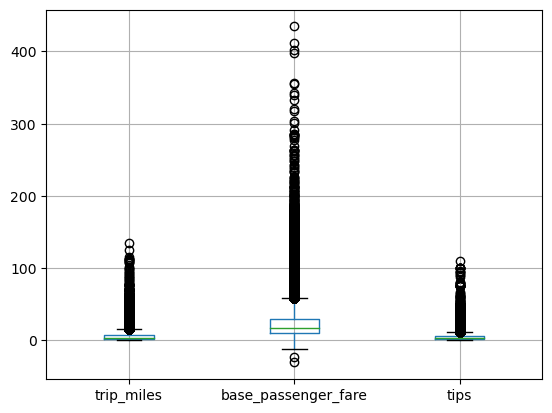

In [70]:
#Solution: box plot
df_tiny.boxplot()

## Exercise:

- Play with the pandas dataframe `df_tiny`to get insights on good filters for the bigger dataframe. 

Hint: think about quantiles

In [86]:
#soultion
df_tiny.tips.quantile([0.25, 0.75])

0.25    2.00
0.75    5.66
Name: tips, dtype: float64

In [87]:
df_tiny.base_passenger_fare.quantile([0.25, 0.75])

0.25    10.740000
0.75    29.809999
Name: base_passenger_fare, dtype: float64

In [85]:
df_tiny.trip_miles.quantile([0.25, 0.75])

0.25    1.719
0.75    7.090
Name: trip_miles, dtype: float64

In [ ]:
tips_condition = (df_tiny.tips.between(*df_tiny.tips.quantile([0.25, 0.75]).values))

In [80]:
tips_condition

request_datetime
2019-02-01 10:18:21     True
2019-02-01 17:44:25     True
2019-02-01 21:57:00     True
2019-02-01 10:28:55     True
2019-02-01 21:00:15     True
                       ...  
2022-09-30 17:44:07    False
2022-09-30 16:06:26    False
2022-09-30 23:07:40     True
2022-09-30 16:03:44     True
2022-09-30 20:30:22     True
Name: tips, Length: 109096, dtype: bool

In [95]:
## Solution
tips_condition = (df_tiny.tips.between(*df_tiny.tips.quantile([0.25, 0.75]).values))

fares_condition = (df_tiny.base_passenger_fare.between(*df_tiny.base_passenger_fare.quantile([0.25, 0.75]).values))

trips_condition = (df_tiny.trip_miles.between(*df_tiny.trip_miles.quantile([0.25, 0.75]).values))

<AxesSubplot: >

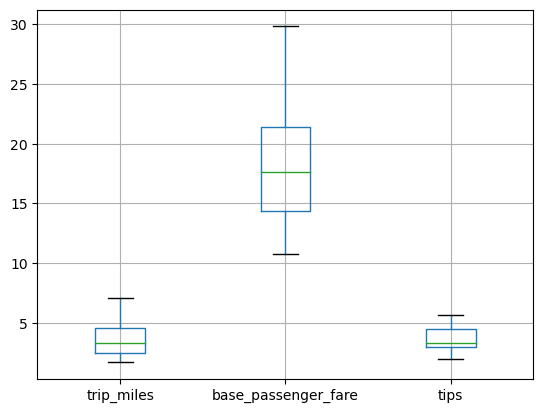

In [96]:
#solution
df_tiny.loc[(tips_condition & fares_condition) & trips_condition].boxplot()

## Filtering our big dataset based on the insights

Based on these numbers let's go back to our `df_small` dataset and try to filter it.

**Note: **

Sometimes when you are trying to filter and you have been doing feature engineering, you might get a divisions not known error.
If that's the case you can do 

```python
df_small = df_small.reset_index()
df_small = df_small.set_index("column_to_be_the_index").persist()
```

In [91]:
tips_q1q3 = (2, 5.66)
trips_q1q3 = (1.71 , 7.09)
fares_q1q3 = (10.74, 29.80)

In [99]:
tips_condition = df_small.tips.between(*tips_q1q3)
trips_condition = df_small.trip_miles.between(*trips_q1q3)
fares_condition = df_small.base_passenger_fare.between(*fares_q1q3)

In [100]:
df_small = df_small.loc[(tips_condition & fares_condition) & trips_condition].persist()

In [101]:
df_small.groupby('hvfhs_license_num').dolars_per_mile.agg(["min", "max", "mean", "std"]).compute()

,min,max,mean,std
hvfhs_license_num,,,,
HV0003,1.516220,17.426899,5.590027,1.988093
HV0002,1.607649,17.362574,4.903812,1.683105
HV0005,1.517163,17.400702,5.313314,1.673097
HV0004,1.517630,17.409357,4.763032,2.037534


In [102]:
tips_perc_avg = df_small.groupby('hvfhs_license_num').tip_percentage.mean().compute()

In [103]:
tips_perc_avg.to_frame().set_index(tips_perc_mean.index.map(provider))

,tip_percentage
hvfhs_license_num,
Juno,0.203971
Uber,0.206005
Lyft,0.206566
Via,0.177475


In [104]:
len(df_small)

32159241

## What we've learn
- Most New Yorkers do not tip
- But it looks like of those who tip, it is common to tip around 20% regardless of the provider. Unless it's Via, they tend to tip slightly less.

NOTES to include in text:




note: on pandas efficent creating columns 
https://stackoverflow.com/questions/52289488/efficient-way-to-add-new-column-to-pandas-dataframe